트레이닝

In [ ]:
!pip install ffmpeg-python>=0.2.0
!pip install matplotlib>=3.0.2
!pip install munkres>=1.1.2
!pip install numpy>=1.16
!pip install opencv-python>=3.4
!pip install Pillow>=5.4
!pip install vidgear>=0.1.4
!pip install torch>=1.4.0
!pip install torchvision>=0.5.0
!pip install tqdm>=4.26
!pip install tensorboard>=1.11
!pip install tensorboardX>=1.4

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/dacon_pose/hrnet

/content/drive/MyDrive/dacon_pose/hrnet


In [ ]:
loss_history = []

In [ ]:
import os
from datetime import datetime

import tensorboardX as tb
import torch
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from datasets.HumanPoseEstimation import HumanPoseEstimationDataset
from losses.loss import JointsMSELoss, JointsOHKMMSELoss
from misc.checkpoint import save_checkpoint, load_checkpoint
from misc.utils import flip_tensor, flip_back
from misc.visualization import save_images
from models.hrnet import HRNet

class Train(object):
    """
    Train  class.

    The class provides a basic tool for training HRNet.
    Most of the training options are customizable.

    The only method supposed to be directly called is `run()`.
    """

    def __init__(self,
                 exp_name,
                 ds_train,
                 ds_val,
                 epochs=80,
                 batch_size=16,
                 num_workers=4,
                 loss='JointsMSELoss',
                 lr=0.0001,
                 lr_decay=True,
                 lr_decay_steps=(65, 75),
                 lr_decay_gamma=0.1,
                 optimizer='Adam',
                 weight_decay=0.,
                 momentum=0.9,
                 nesterov=False,
                 pretrained_weight_path=None,
                 checkpoint_path=None,
                 log_path='./logs',
                 use_tensorboard=True,
                 model_c=48,
                 model_nof_joints=17,
                 model_bn_momentum=0.1,
                 flip_test_images=False,
                 device=None
                 ):
        """
        Initializes a new Train object.

        The log folder is created, the HRNet model is initialized and optional pre-trained weights or saved checkpoints
        are loaded.
        The DataLoaders, the loss function, and the optimizer are defined.

        Args:
            exp_name (str):  experiment name.
            ds_train (HumanPoseEstimationDataset): train dataset.
            ds_val (HumanPoseEstimationDataset): validation dataset.
            epochs (int): number of epochs.
                Default: 210
            batch_size (int): batch size.
                Default: 16
            num_workers (int): number of workers for each DataLoader
                Default: 4
            loss (str): loss function. Valid values are 'JointsMSELoss' and 'JointsOHKMMSELoss'.
                Default: "JointsMSELoss"
            lr (float): learning rate.
                Default: 0.001
            lr_decay (bool): learning rate decay.
                Default: True
            lr_decay_steps (tuple): steps for the learning rate decay scheduler.
                Default: (170, 200)
            lr_decay_gamma (float): scale factor for each learning rate decay step.
                Default: 0.1
            optimizer (str): network optimizer. Valid values are 'Adam' and 'SGD'.
                Default: "Adam"
            weight_decay (float): weight decay.
                Default: 0.
            momentum (float): momentum factor.
                Default: 0.9
            nesterov (bool): Nesterov momentum.
                Default: False
            pretrained_weight_path (str): path to pre-trained weights (such as weights from pre-train on imagenet).
                Default: None
            checkpoint_path (str): path to a previous checkpoint.
                Default: None
            log_path (str): path where tensorboard data and checkpoints will be saved.
                Default: "./logs"
            use_tensorboard (bool): enables tensorboard use.
                Default: True
            model_c (int): hrnet parameters - number of channels.
                Default: 48
            model_nof_joints (int): hrnet parameters - number of joints.
                Default: 17
            model_bn_momentum (float): hrnet parameters - path to the pretrained weights.
                Default: 0.1
            flip_test_images (bool): flip images during validating.
                Default: True
            device (torch.device): device to be used (default: cuda, if available).
                Default: None
        """
        super(Train, self).__init__()

        self.exp_name = exp_name
        self.ds_train = ds_train
        self.ds_val = ds_val
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.loss = loss
        self.lr = lr
        self.lr_decay = lr_decay
        self.lr_decay_steps = lr_decay_steps
        self.lr_decay_gamma = lr_decay_gamma
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.nesterov = nesterov
        self.pretrained_weight_path = pretrained_weight_path
        self.checkpoint_path = checkpoint_path
        self.log_path = os.path.join(log_path, self.exp_name)
        self.use_tensorboard = use_tensorboard
        self.model_c = model_c
        self.model_nof_joints = model_nof_joints
        self.model_bn_momentum = model_bn_momentum
        self.flip_test_images = flip_test_images
        self.epoch = 0

        # torch device
        if device is not None:
            self.device = device
        else:
            if torch.cuda.is_available():
                self.device = torch.device('cuda:0')
            else:
                self.device = torch.device('cpu')

        print(self.device)

        os.makedirs(self.log_path, 0o755, exist_ok=False)  # exist_ok=False to avoid overwriting
        if self.use_tensorboard:
            self.summary_writer = tb.SummaryWriter(self.log_path)

        #
        # write all experiment parameters in parameters.txt and in tensorboard text field
        self.parameters = [x + ': ' + str(y) + '\n' for x, y in locals().items()]
        with open(os.path.join(self.log_path, 'parameters.txt'), 'w') as fd:
            fd.writelines(self.parameters)
        if self.use_tensorboard:
            self.summary_writer.add_text('parameters', '\n'.join(self.parameters))

        #
        # load model
        self.model = HRNet(c=self.model_c, nof_joints=self.model_nof_joints,
                           bn_momentum=self.model_bn_momentum).to(self.device)

        #
        # define loss and optimizers
        if self.loss == 'JointsMSELoss':
            self.loss_fn = JointsMSELoss().to(self.device)
        elif self.loss == 'JointsOHKMMSELoss':
            self.loss_fn = JointsOHKMMSELoss().to(self.device)
        else:
            raise NotImplementedError

        if optimizer == 'SGD':
            self.optim = SGD(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay,
                             momentum=self.momentum, nesterov=self.nesterov)
        elif optimizer == 'Adam':
            self.optim = Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise NotImplementedError

        #
        # load pre-trained weights (such as those pre-trained on imagenet)
        if self.pretrained_weight_path is not None:
            missing_keys, unexpected_keys = self.model.load_state_dict(
                torch.load(self.pretrained_weight_path, map_location=self.device),
                strict=False  # strict=False is required to load models pre-trained on imagenet
            )
            print('Pre-trained weights loaded.')
            if len(missing_keys) > 0 or len(unexpected_keys) > 0:
                print('Pre-trained weights missing keys:', missing_keys)
                print('Pre-trained weights unexpected keys:', unexpected_keys)

        #
        # load previous checkpoint
        if self.checkpoint_path is not None:
            print('Loading checkpoint %s...' % self.checkpoint_path)
            if os.path.isdir(self.checkpoint_path):
                path = os.path.join(self.checkpoint_path, 'checkpoint_last.pth')
            else:
                path = self.checkpoint_path
            self.starting_epoch, self.model, self.optim, self.params = load_checkpoint(path, self.model, self.optim,
                                                                                       self.device)
        else:
            self.starting_epoch = 0

        if lr_decay:
            self.lr_scheduler = MultiStepLR(self.optim, list(self.lr_decay_steps), gamma=self.lr_decay_gamma,
                                            last_epoch=self.starting_epoch if self.starting_epoch else -1)

        #
        # load train and val datasets
        self.dl_train = DataLoader(self.ds_train, batch_size=self.batch_size, shuffle=True,
                                   num_workers=self.num_workers, drop_last=True)
        self.len_dl_train = len(self.dl_train)

        # dl_val = DataLoader(self.ds_val, batch_size=1, shuffle=False, num_workers=num_workers)
        self.dl_val = DataLoader(self.ds_val, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        self.len_dl_val = len(self.dl_val)

        #
        # initialize variables
        self.mean_loss_train = 0.
        self.mean_acc_train = 0.
        self.mean_loss_val = 0.
        self.mean_acc_val = 0.
        self.mean_mAP_val = 0.

        self.best_loss = None
        self.best_acc = None
        self.best_mAP = None

    def _train(self):
        self.model.train()

        for step, (image, target, target_weight, joints_data) in enumerate(tqdm(self.dl_train, desc='Training')):
            image = image.to(self.device)
            target = target.to(self.device)
            target_weight = target_weight.to(self.device)
            
            self.optim.zero_grad()

            output = self.model(image)

            loss = self.loss_fn(output, target, target_weight)

            loss.backward()

            self.optim.step()

            # Evaluate accuracy
            # Get predictions on the input
            #accs, avg_acc, cnt, joints_preds, joints_target = self.ds_train.evaluate_accuracy(output, target)
            #acc_history.append(avg_acc)

            self.mean_loss_train += loss.item()

        self.mean_loss_train /= len(self.dl_train)
        loss_history.append(self.mean_loss_train)


        print('\nTrain: Loss %f ' % (self.mean_loss_train))

    # def _val(self):
    #     self.model.eval()

    #     with torch.no_grad():
    #         for step, (image, target, target_weight, joints_data) in enumerate(tqdm(self.dl_val, desc='Validating')):
    #             image = image.to(self.device)
    #             target = target.to(self.device)
    #             target_weight = target_weight.to(self.device)
                
    #             output = self.model(image)

    #             # if self.flip_test_images:
    #             #     image_flipped = flip_tensor(image, dim=-1)
    #             #     output_flipped = self.model(image_flipped)

    #             #     output_flipped = flip_back(output_flipped, self.ds_val.flip_pairs)

    #             #     output = (output + output_flipped) * 0.5

    #             loss = self.loss_fn(output, target, target_weight)

    #             # Evaluate accuracy
    #             # Get predictions on the input
    #             accs, avg_acc, cnt, joints_preds, joints_target = \
    #                 self.ds_val.evaluate_accuracy(output, target)

    #             self.mean_loss_val += loss.item()
    #             self.mean_acc_val += avg_acc.item()
    #             self.len_dl_val = len(self.dl_val)
    #             if self.use_tensorboard:
    #                 self.summary_writer.add_scalar('val_loss', loss.item(),
    #                                                global_step=step + self.epoch * self.len_dl_val)
    #                 self.summary_writer.add_scalar('val_acc', avg_acc.item(),
    #                                                global_step=step + self.epoch * self.len_dl_val)
    #                 if step == 0:
    #                     save_images(image, target, joints_target, output, joints_preds,
    #                                 joints_data['joints_visibility'], self.summary_writer,
    #                                 step=step + self.epoch * self.len_dl_val, prefix='val_')

    #     self.mean_loss_val /= len(self.dl_val)
    #     self.mean_acc_val /= len(self.dl_val)

    #     print('\nValidation: Loss %f - Accuracy %f' % (self.mean_loss_val, self.mean_acc_val))

    def _checkpoint(self):

        save_checkpoint(path=os.path.join(self.log_path, 'checkpoint_last.pth'), epoch=self.epoch + 1, model=self.model,
                        optimizer=self.optim, params=self.parameters)
        if self.epoch == 5 or self.epoch % 10 == 0 or (self.epoch % 4 == 0 and self.epoch >=80):
            save_checkpoint(path=os.path.join(self.log_path, 'checkpoint_{}epoch.pth'.format(self.epoch+1)), epoch=self.epoch + 1,
                             model=self.model, optimizer=self.optim, params=self.parameters)

#         if self.best_loss is None or self.best_loss > self.mean_loss_val:
#             self.best_loss = self.mean_loss_val
#             print('best_loss %f at epoch %d' % (self.best_loss, self.epoch + 1))
#             save_checkpoint(path=os.path.join(self.log_path, 'checkpoint_best_loss.pth'), epoch=self.epoch + 1,
#                             model=self.model, optimizer=self.optim, params=self.parameters)
#         if self.best_acc is None or self.best_acc < self.mean_acc_val:
#             self.best_acc = self.mean_acc_val
#             print('best_acc %f at epoch %d' % (self.best_acc, self.epoch + 1))
#             save_checkpoint(path=os.path.join(self.log_path, 'checkpoint_best_acc.pth'), epoch=self.epoch + 1,
#                             model=self.model, optimizer=self.optim, params=self.parameters)
#         if self.best_mAP is None or self.best_mAP < self.mean_mAP_val:
#             self.best_mAP = self.mean_mAP_val
#             print('best_mAP %f at epoch %d' % (self.best_mAP, self.epoch + 1))
#             save_checkpoint(path=os.path.join(self.log_path, 'checkpoint_best_mAP.pth'), epoch=self.epoch + 1,
#                             model=self.model, optimizer=self.optim, params=self.parameters)

    def run(self):
        """
        Runs the training.
        """

        print('\nTraining started @ %s' % datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

        # start training
        for self.epoch in range(self.starting_epoch, self.epochs):
            print('\nEpoch %d of %d @ %s' % (self.epoch + 1, self.epochs, datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

            self.mean_loss_train = 0.
            self.mean_loss_val = 0.
            self.mean_acc_train = 0.
            self.mean_acc_val = 0.
            self.mean_mAP_val = 0.

            # Train
            self._train()

            # Val
            #self._val()

            #
            # LR Update

            if self.lr_decay:
                self.lr_scheduler.step()

            #
            # Checkpoint
            self._checkpoint()

            #Show error rate

        print('\nTraining ended @ %s' % datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


In [ ]:
cd ..

/content/drive/MyDrive/dacon_pose


In [2]:
pwd

'/content'

In [ ]:
ds_train = HumanPoseEstimationDataset()
ds_val = HumanPoseEstimationDataset()

train = Train(exp_name = 'lr=0.0001', ds_train = ds_train, ds_val = ds_val,
              model_nof_joints = 24, num_workers = 2, batch_size=6,
              pretrained_weight_path='pose_hrnet_m24j.pth')

cuda:0


In [ ]:
train.run()

print(loss_history)

from matplotlib import pyplot as plt

plot_x = []
for i in range(1,81):
  plot_x.append(i)


plt.plot(plot_x, loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss per epoch')

plt.show()


Training started @ 2022-06-05 02:10:22

Epoch 1 of 80 @ 2022-06-05 02:10:22


Training: 100%|██████████| 682/682 [06:25<00:00,  1.77it/s]



Train: Loss 0.008129 

Epoch 2 of 80 @ 2022-06-05 02:16:52


Training: 100%|██████████| 682/682 [05:22<00:00,  2.11it/s]



Train: Loss 0.002575 

Epoch 3 of 80 @ 2022-06-05 02:22:17


Training: 100%|██████████| 682/682 [05:21<00:00,  2.12it/s]



Train: Loss 0.001305 

Epoch 4 of 80 @ 2022-06-05 02:27:41


Training: 100%|██████████| 682/682 [05:22<00:00,  2.12it/s]



Train: Loss 0.000916 

Epoch 5 of 80 @ 2022-06-05 02:33:06


Training: 100%|██████████| 682/682 [05:24<00:00,  2.10it/s]



Train: Loss 0.000719 

Epoch 6 of 80 @ 2022-06-05 02:38:32


Training: 100%|██████████| 682/682 [05:22<00:00,  2.12it/s]



Train: Loss 0.000584 

Epoch 7 of 80 @ 2022-06-05 02:43:59


Training: 100%|██████████| 682/682 [05:22<00:00,  2.12it/s]



Train: Loss 0.000486 

Epoch 8 of 80 @ 2022-06-05 02:49:24


Training:  96%|█████████▌| 656/682 [05:10<00:12,  2.11it/s]


KeyboardInterrupt: ignored

## 예측




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from typing import Tuple, List, Sequence, Callable, Dict
import numpy as np


In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/hrnet')
from SimpleHRNet import SimpleHRNet


In [ ]:
os.chdir('/content/drive/Shareddrives/ML_TeamProject/dacon_pose')

In [ ]:
os.getcwd()

'/content/drive/Shareddrives/ML_TeamProject/dacon_pose'

In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/train_df.csv')
error_list=[317, 869, 873, 877, 911, 1559, 1560, 1562, 1566, 1575, 1577, 1578, 1582, 1606, 1607, 1622, 1623, 1624, 1625, 1629, 3968, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194]
train_df = train_df.drop(error_list)
x_sam = np.mean(train_df.iloc[:,1::2], axis = 0)
y_sam = np.mean(train_df.iloc[:,2::2], axis = 0)
sample = np.zeros(48)
for i in range(48):
    if i %2 ==0:
        sample[i] = x_sam[i//2]
    else:
        sample[i] = y_sam[i//2]
sample

array([926.76267619, 467.32724241, 927.78669222, 460.54445377,
       923.51702446, 460.88543023, 930.41187011, 465.53528734,
       924.56441786, 466.15626693, 944.44766429, 503.05779306,
       926.29888204, 505.55905987, 951.39112335, 552.1191711 ,
       922.92730597, 555.18788932, 947.91943219, 585.5828699 ,
       928.37867953, 586.7570758 , 962.08199207, 610.03945056,
       952.97433835, 610.77638458, 974.02681736, 679.17405732,
       964.25218172, 677.59057907, 985.44105208, 774.2588151 ,
       977.33498944, 772.76200385, 931.80968939, 484.34587402,
       946.54873415, 589.86519932, 929.08348833, 591.19573359,
       941.41143818, 530.11093851, 950.92679421, 573.33900987,
       987.55515372, 791.57679227, 979.09345196, 789.84683029])

In [ ]:
import glob
test_img_list = glob.glob('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/*.jpg')

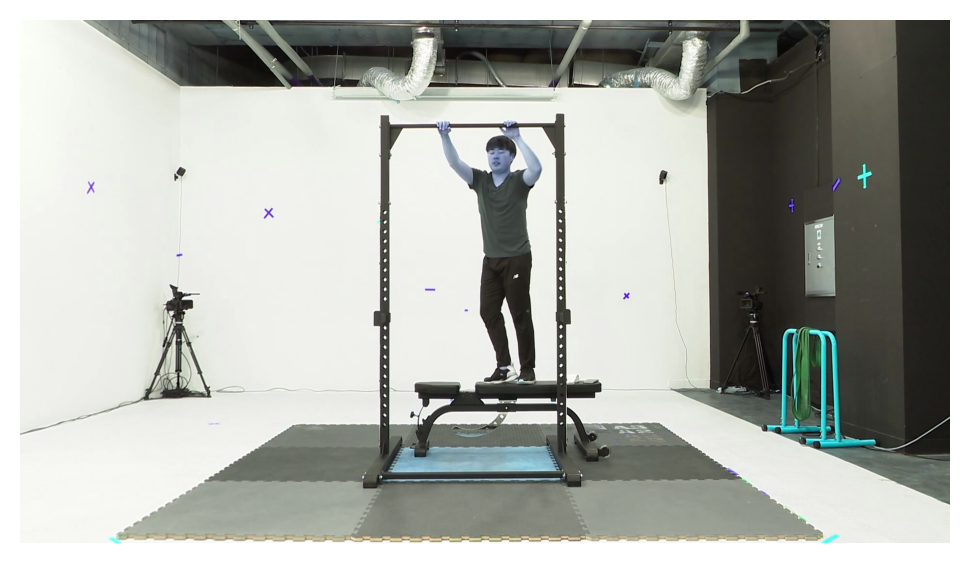

In [ ]:
image = cv2.imread(test_img_list[0], cv2.IMREAD_COLOR)
fig, ax = plt.subplots(dpi=200)
ax.imshow(image)
ax.axis('off')
plt.show()



In [ ]:
os.chdir('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/hrnet')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/dacon_pose/hrnet'

In [ ]:
import cv2
from SimpleHRNet import SimpleHRNet
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

# /content/drive/MyDrive/dacon_pose/logs/mytest3/
# /content/drive/Shareddrives/ML_TeamProject/dacon_pose/hrnet/logs/dacon_test2-3-backup/
epoch_list=['1epoch','6epoch','11epoch','21epoch','31epoch','41epoch','51epoch','61epoch','71epoch','last']


for epo in epoch_list:
  model = SimpleHRNet(48, 24, '/content/drive/Shareddrives/ML_TeamProject/dacon_pose/logs/'+'usingSGD'+'/checkpoint_'+epo+'.pth', device = torch.device('cuda:0'), multiperson = True) 
  count = 0
  zero_box_num = 0
  large_box_index = []
  large_box_case = []

  test_df = pd.DataFrame(columns = train_df.columns)

  for i, img in enumerate(test_img_list):
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    print(img)
    size = image.shape
    image = cv2.resize(image, (1333, 800))
    joints = model.predict(image)
    if joints.size !=0:
      if joints.ndim > 2 and joints.shape[0] > 1:
          large_box_index.append(i)
          large_box_case.append(joints)
      joints = joints[0,:,:2]
      keypoints = np.array([[y, x] for x, y in joints])
      keypoints *= np.array([size[1]/1333, size[0]/800])
      keypoints = keypoints.astype(np.float)

    else:
      zero_box_num +=1
      keypoints = sample.astype(np.int16)
    row = np.concatenate((np.array([img]), keypoints.flatten()), axis = 0)
    test_df = test_df.append(pd.Series(row, index = train_df.columns[:49]), ignore_index = True)
    count+=1
    if count%100 == 0:
      print('{} imgs predicted'.format(count))


  test_df['image'] = test_df['image'].map(lambda x:x.split('/')[-1])

  test_df.to_csv('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_result/SGD_test_'+epo+'.csv', index = False)

  answer = pd.read_csv('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_answer.csv') # 원래 좌표
  data = pd.read_csv('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_result/SGD_test_'+epo+'.csv')

  df= answer

  for i in range(0,1600):
      df.iloc[i,1:49]=df.iloc[i,1:49]-data[data['image']==answer.iloc[i,0]].iloc[0,1:49]

  df.to_csv("/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_result/SGD_gap_"+epo+".csv", index=False)

  zeros=[]
  for i in range(0,1600):
      zeros.append(0)

  df = df.assign(RMSE = zeros)


  for i in range(0,1600):
      sum=0
      for j in range(1,49):
          sum+=df.iloc[i,j]*df.iloc[i,j]
      df.iloc[i,49]= (sum/48)**(1/2)
      print("완료"+str(i)+"개")

  df.to_csv("/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_result/SGD_RMSE_"+epo+".csv", index=False)

##### rmse_sum
import pandas as pd
RMSE_sum = pd.DataFrame(data=[0,0,0,0,0,0,0,0,0,0],index=epoch_list,columns=['RMSE_sum'])

for i in epoch_list:
    df=pd.read_csv('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_result/RMSE_'+i+'.csv')
    rmse_sum=0
    for j in range(0,1600):
        rmse_sum+=(df.iloc[j,49])
    RMSE_sum.loc[i,'RMSE_sum']=rmse_sum/1600

RMSE_sum.to_csv('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_result/SGD_RMSE_RMSE_sum.csv')



device: 'cuda' - GPU(s) 'cuda:0' will be used
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/730-3-5-36-Z94_C-0000027.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Streaming output truncated to the last 5000 lines.
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/737-3-5-37-Z94_E-0000027.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/730-3-5-36-Z94_C-0000003.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/761-3-5-39-Z94_C-0000013.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/738-3-5-37-Z94_B-0000007.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/737-3-5-37-Z94_E-0000021.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/761-3-5-39-Z94_A-0000001.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/761-3-5-39-Z94_B-0000003.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/761-3-5-39-Z94_B-0000009.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/738-3-5-37-Z94_B-0000009.jpg
/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_imgs/730-3-5-36-Z94_C-0000023.jpg
/content/drive/Shar

FileNotFoundError: ignored

In [4]:
import pandas as pd
epoch_list=['1epoch','6epoch','11epoch','21epoch','31epoch','41epoch','51epoch','61epoch','71epoch','last']
RMSE_sum = pd.DataFrame(data=[0,0,0,0,0,0,0,0,0,0],index=epoch_list,columns=['RMSE_sum'])

for i in epoch_list:
    df=pd.read_csv('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_result/SGD_RMSE_'+i+'.csv')
    rmse_sum=0
    for j in range(0,1600):
        rmse_sum+=(df.iloc[j,49])
    RMSE_sum.loc[i,'RMSE_sum']=rmse_sum/1600

RMSE_sum.to_csv('/content/drive/Shareddrives/ML_TeamProject/dacon_pose/test_result/SGD_RMSE_sum lr=0.0001.csv')